# Machine Unlearning

## Baseline approach

In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.metrics import confusion_matrix

In [2]:
import random
torch.manual_seed(42)
np.random.seed(42)
random.seed(0)

torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
def load_data(exclude_class=None, relabel_class=None, relabel_to=None):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    # Load full datasets
    train_set = datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_set = datasets.MNIST('./data', train=False, transform=transform)

    # Apply exclusion logic if `exclude_class` is specified
    if exclude_class is not None:
        train_indices = [i for i, t in enumerate(train_set.targets) if t != exclude_class]
        test_indices = [i for i, t in enumerate(test_set.targets) if t != exclude_class]
    else:
        train_indices = list(range(len(train_set)))
        test_indices = list(range(len(test_set)))

    # Apply relabeling logic if `relabel_class` is specified
    if relabel_class is not None and relabel_to is not None:
        # Relabel '6' as '3'
        train_set.targets[train_set.targets == relabel_class] = relabel_to
        test_set.targets[test_set.targets == relabel_class] = relabel_to

    # Subset the dataset to include only selected indices
    train_subset = Subset(train_set, train_indices)
    test_subset = Subset(test_set, test_indices)

    return (
        DataLoader(train_subset, batch_size=128, shuffle=True, num_workers=2, pin_memory=True),
        DataLoader(test_subset, batch_size=1000, shuffle=False, num_workers=2, pin_memory=True)
    )


In [5]:
# Define the CNN model
class MNISTClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x


In [6]:
# Training function
def train_model(model, train_loader, test_loader, device, epochs=10):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    model.train()
    for epoch in range(epochs):
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        test_loss = 0
        correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                test_loss += criterion(output, target).item()
                pred = output.argmax(dim=1)
                correct += pred.eq(target).sum().item()

        test_loss /= len(test_loader)
        acc = 100. * correct / len(test_loader.dataset)
        print(f'Epoch {epoch+1}: Test loss: {test_loss:.4f}, Accuracy: {acc:.1f}%')
        model.train()

    # torch.save(model.state_dict(), save_path)
    # print(f'Model saved to {save_path}')

### Pretrain

In [7]:
original_model = MNISTClassifier().to(device)
train_loader_old, test_loader_old = load_data(exclude_class=3)
train_model(original_model, train_loader_old, test_loader_old, device, epochs=5)

Epoch 1: Test loss: 0.0551, Accuracy: 98.1%
Epoch 2: Test loss: 0.0448, Accuracy: 98.7%
Epoch 3: Test loss: 0.0341, Accuracy: 98.9%
Epoch 4: Test loss: 0.0343, Accuracy: 98.9%
Epoch 5: Test loss: 0.0416, Accuracy: 99.0%


### Retrain

In [8]:
retrained_model = MNISTClassifier().to(device)
train_loader_new, test_loader_new = load_data(relabel_class=6, relabel_to=3)
train_model(retrained_model, train_loader_new, test_loader_new, device, epochs=5)

Epoch 1: Test loss: 0.0477, Accuracy: 98.4%
Epoch 2: Test loss: 0.0415, Accuracy: 98.6%
Epoch 3: Test loss: 0.0366, Accuracy: 98.8%
Epoch 4: Test loss: 0.0352, Accuracy: 99.0%
Epoch 5: Test loss: 0.0332, Accuracy: 99.0%


### Finetune

In [9]:
def finetune_model(model, train_loader, device, lambda_param=0.1, epochs=5, top_k=32):
    # Identify critical parameters for class 6
    with torch.no_grad():
        # Get weights connecting to class 6
        class6_weights = model.fc2.weight[6].abs()
        # Find most important neurons in previous layer
        _, important_neurons = torch.topk(class6_weights, top_k)

    # Create gradient masks for selective training
    fc1_weight_mask = torch.zeros_like(model.fc1.weight)
    fc1_weight_mask[important_neurons] = 1
    fc1_bias_mask = torch.zeros_like(model.fc1.bias)
    fc1_bias_mask[important_neurons] = 1

    # Allow updates to class 3 and 6 in final layer
    fc2_mask = torch.zeros_like(model.fc2.weight)
    fc2_mask[[3,6]] = 1  # Classes 3 and 6
    fc2_bias_mask = torch.zeros_like(model.fc2.bias)
    fc2_bias_mask[[3,6]] = 1

    # Freeze all parameters first
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze parameters we want to modify
    model.fc1.weight.requires_grad = True
    model.fc1.bias.requires_grad = True
    model.fc2.weight.requires_grad = True
    model.fc2.bias.requires_grad = True

    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

    model.train()
    for epoch in range(epochs):
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            # Remap class 6 to class 3
            target[target == 6] = 3

            optimizer.zero_grad()
            output = model(data)

            # Combined loss function
            ce_loss = F.cross_entropy(output, target)
            suppress_loss = torch.mean(output[:, 6]**2)  # Penalize class 6 confidence
            loss = ce_loss + lambda_param * suppress_loss

            loss.backward()

            # Apply gradient masking
            model.fc1.weight.grad *= fc1_weight_mask.to(device)
            model.fc1.bias.grad *= fc1_bias_mask.to(device)
            model.fc2.weight.grad *= fc2_mask.to(device)
            model.fc2.bias.grad *= fc2_bias_mask.to(device)

            optimizer.step()

    return model

In [10]:
unlearned_model = MNISTClassifier().to(device)
unlearned_model.load_state_dict(original_model.state_dict())
finetune_model(unlearned_model, train_loader_new, device, lambda_param=0.1, epochs=5)

MNISTClassifier(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

### Evaluation

In [11]:
def evaluate_model(model, test_loader, device):
    model.eval()  # Set model to evaluation mode
    test_loss = 0.0
    correct = 0
    total_samples = 0

    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():  # Disable gradient computation for inference
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)

            # Get model predictions
            output = model(data)

            # Calculate batch loss
            batch_loss = criterion(output, target)
            test_loss += batch_loss.item() * data.size(0)  # Accumulate loss for each sample in the batch

            # Get predicted classes
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()  # Count correct predictions
            total_samples += data.size(0)  # Accumulate total number of samples

    # Compute average loss per sample
    test_loss /= total_samples
    accuracy = 100. * correct / total_samples  # Calculate accuracy

    print(f'Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.1f}%')

    # return test_loss, accuracy


def evaluate_class_performance(model, dataloader, target_class, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            mask = (target == target_class)  # Select only samples of target_class
            if mask.sum() == 0:
                continue  # Skip if batch has no target_class samples

            data, target = data[mask], target[mask]
            output = model(data)
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += target.size(0)

    acc = 100. * correct / total if total > 0 else 0
    return acc


def collect_logits(model, data_loader, device):
    """Collects all logits from a model for a given dataset."""
    model.eval()
    logits_list = []

    with torch.no_grad():
        for data, _ in data_loader:
            data = data.to(device)
            logits = model(data)
            logits_list.append(logits.cpu().flatten())

    return torch.cat(logits_list).numpy()


def compute_confusion_matrix(model, dataloader, device, num_classes):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            preds = output.argmax(dim=1)  # Get predicted class

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(target.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=np.arange(num_classes))
    return cm

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()


def plot_logit_histograms(model1, model2, data_loader, device, class_label=6):
    """Plots histograms of logits for a specific class (class_label) from two models."""
    model1.eval()
    model2.eval()

    logits_model1 = []
    logits_model2 = []

    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)

            # Get logits from both models
            logits1 = model1(data)
            logits2 = model2(data)

            # Extract logits for the specific class (class_label)
            logits_model1.extend(logits1[:, class_label].cpu().numpy())
            logits_model2.extend(logits2[:, class_label].cpu().numpy())

    # Plot histograms for logits of class 6 for both models
    plt.figure(figsize=(10, 6))
    plt.hist(logits_model1, bins=50, alpha=0.5, label=f'Model 1 - Class {class_label}')
    plt.hist(logits_model2, bins=50, alpha=0.5, label=f'Model 2 - Class {class_label}')
    plt.xlabel('Logits')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of Logits for Class {class_label} - Model Comparison')
    plt.legend(loc='best')
    plt.show()

In [12]:
print("Original Model on old data:")
evaluate_model(original_model, test_loader_old, device)
print("On modified data:")
evaluate_model(original_model, test_loader_new, device)

Original Model on old data:
Test Loss: 0.0416, Accuracy: 99.0%
On modified data:
Test Loss: 5.1515, Accuracy: 79.6%


In [13]:
print("Retrained Model on old data:")
evaluate_model(retrained_model, test_loader_old, device)
print("On modified data:")
evaluate_model(retrained_model, test_loader_new, device)

Retrained Model on old data:
Test Loss: 2.9196, Accuracy: 88.4%
On modified data:
Test Loss: 0.0332, Accuracy: 99.0%


In [14]:
print("Unlearned Model on old data:")
evaluate_model(unlearned_model, test_loader_old, device)
print("On modified data:")
evaluate_model(unlearned_model, test_loader_new, device)

Unlearned Model on old data:
Test Loss: 1.3808, Accuracy: 88.4%
On modified data:
Test Loss: 0.0327, Accuracy: 98.9%


In [15]:
# Evaluate each model on class 3 and class 6
for model_name, model in zip(["Original Model", "Unlearned Model", "Retrained Model"],
                             [original_model, unlearned_model, retrained_model]):
    acc_class_3 = evaluate_class_performance(model, test_loader_new, target_class=3, device=device)
    acc_class_6 = evaluate_class_performance(model, test_loader_old, target_class=6, device=device)

    print(f"{model_name}:")
    print(f"  Accuracy on class 3: {acc_class_3:.2f}%")
    print(f"  Accuracy on class 6: {acc_class_6:.2f}%")
    print()


Original Model:
  Accuracy on class 3: 0.00%
  Accuracy on class 6: 97.39%

Unlearned Model:
  Accuracy on class 3: 98.58%
  Accuracy on class 6: 0.00%

Retrained Model:
  Accuracy on class 3: 99.34%
  Accuracy on class 6: 0.00%



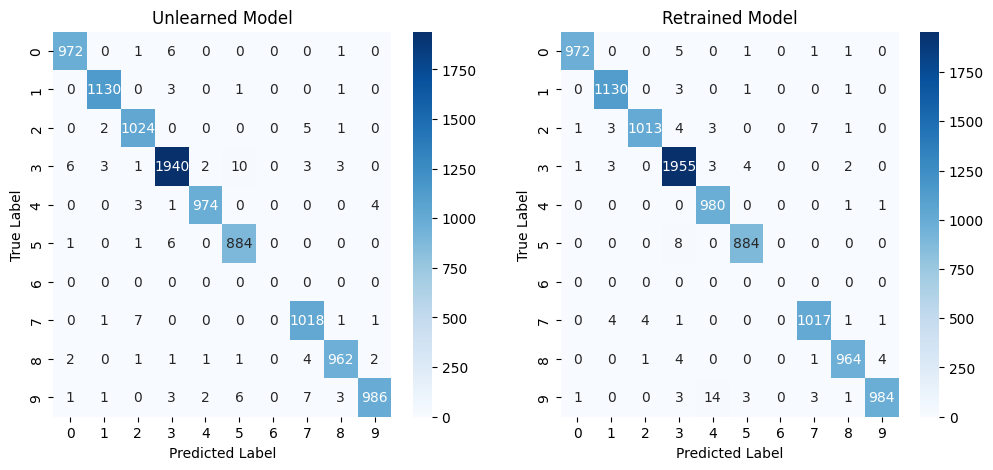

In [16]:
num_classes = 10
class_names = [str(i) for i in range(num_classes)]

cm1 = compute_confusion_matrix(unlearned_model, test_loader_new, device, num_classes)
cm2 = compute_confusion_matrix(retrained_model, test_loader_new, device, num_classes)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for ax, cm, title in zip(axes, [cm1, cm2], ["Unlearned Model", "Retrained Model"]):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names, ax=ax)
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")
    ax.set_title(title)

plt.show()

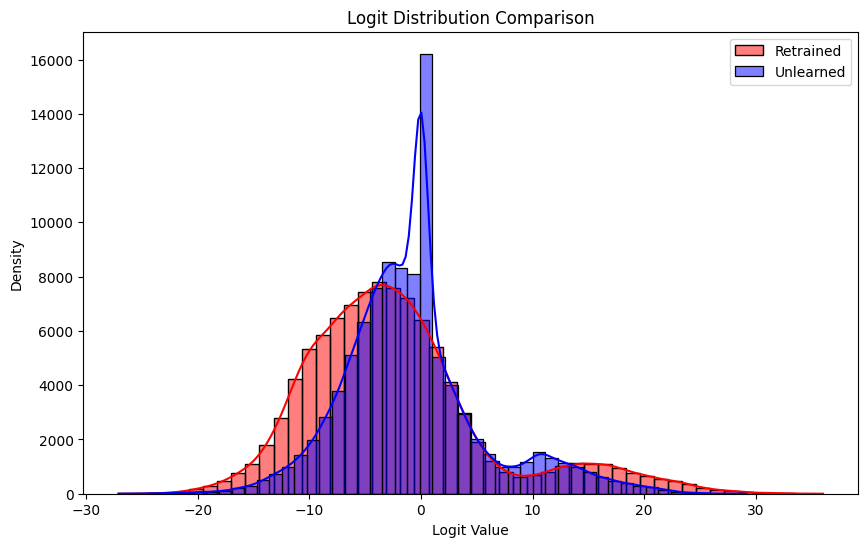

In [17]:
logits_retrained = collect_logits(retrained_model, test_loader_new, device)
logits_unlearned = collect_logits(unlearned_model, test_loader_new, device)

# Plot histograms
plt.figure(figsize=(10, 6))
sns.histplot(logits_retrained, color="red", label="Retrained", bins=50, kde=True)
sns.histplot(logits_unlearned, color="blue", label="Unlearned", bins=50, kde=True)

# Labels and legend
plt.xlabel("Logit Value")
plt.ylabel("Density")
plt.title("Logit Distribution Comparison")
plt.legend()
plt.show()

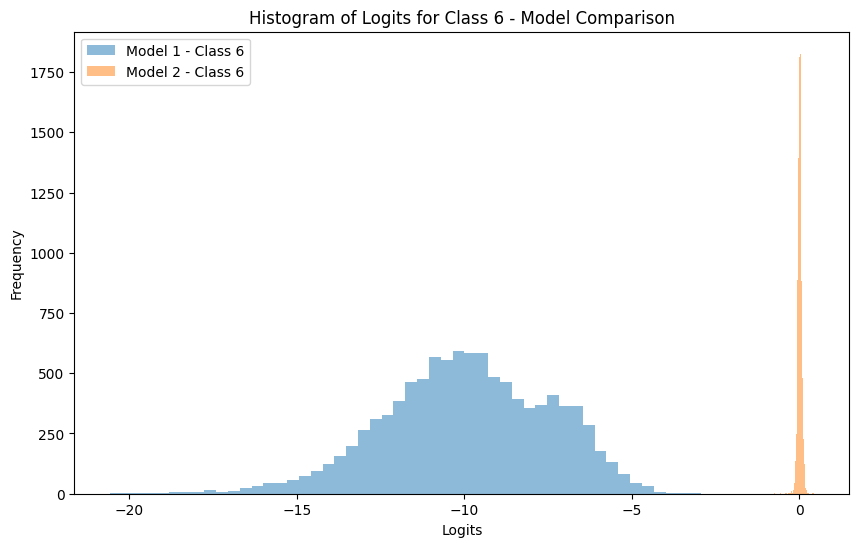

In [18]:
plot_logit_histograms(retrained_model, unlearned_model, test_loader_new, device, class_label=6)

## New Approach

In [19]:
class MNISTMiniTeacher(nn.Module):
    def __init__(self):
        super().__init__()
        # First conv layer: 1 input channel, 8 output channels, 3x3 kernel
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, stride=1)   # Output: 8 x 26 x 26 (28-3+1)
        # Second conv layer: 8 input channels, 16 output channels, 3x3 kernel
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=1)  # Output: 16 x 24 x 24 (26-3+1)
        # Slight dropout to regularize
        self.dropout = nn.Dropout(0.1)
        # After a 2x2 max pooling, the spatial dimensions reduce from 24x24 to 12x12.
        # Hence, flattening produces 16 * 12 * 12 features.
        self.fc1 = nn.Linear(16 * 12 * 12, 32)  # Reduce hidden dimension further
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)  # Reduces each 24x24 feature map to 12x12
        x = self.dropout(x)
        x = torch.flatten(x, 1)  # Flatten all dimensions except batch
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x


In [21]:
teacher = MNISTMiniTeacher().to(device)
train_model(teacher, train_loader_new, test_loader_new, device, epochs=5)

Epoch 1: Test loss: 0.1423, Accuracy: 95.7%
Epoch 2: Test loss: 0.0783, Accuracy: 97.5%
Epoch 3: Test loss: 0.0686, Accuracy: 97.7%
Epoch 4: Test loss: 0.0626, Accuracy: 98.0%
Epoch 5: Test loss: 0.0490, Accuracy: 98.5%
Epoch 6: Test loss: 0.0454, Accuracy: 98.5%
Epoch 7: Test loss: 0.0476, Accuracy: 98.4%
Epoch 8: Test loss: 0.0394, Accuracy: 98.7%
Epoch 9: Test loss: 0.0438, Accuracy: 98.6%
Epoch 10: Test loss: 0.0465, Accuracy: 98.7%


In [22]:
def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Trainable parameters teacher:", count_trainable_parameters(teacher))
print("Trainable parameters original:", count_trainable_parameters(original_model))

Trainable parameters teacher: 75338
Trainable parameters original: 1199882


In [23]:
def distil_unlearn(model, teacher, train_loader, device,
                   lambda_teacher6=0.1, lambda_distill=0.5, temp=2.0,
                   epochs=5, top_k=32):
    """
    Finetune the model using knowledge distillation so that the student (target model)
    has output distributions closer to a teacher model. Instead of simply suppressing
    high activations for class 6, we directly penalize deviations from the teacher's
    logit for class 6.
    """
    # Identify critical parameters for class 6 from fc2
    with torch.no_grad():
        # Get the absolute weights for class 6 (from fc2)
        class6_weights = model.fc2.weight[6].abs()
        # Select top_k most important neurons (indices) in the previous layer
        _, important_neurons = torch.topk(class6_weights, top_k)

    # Create gradient masks for selective training in fc1 (only allow changes for important neurons)
    fc1_weight_mask = torch.zeros_like(model.fc1.weight)
    fc1_weight_mask[important_neurons] = 1
    fc1_bias_mask = torch.zeros_like(model.fc1.bias)
    fc1_bias_mask[important_neurons] = 1

    # Allow updates for classes 3 and 6 in the final layer (fc2)
    fc2_mask = torch.zeros_like(model.fc2.weight)
    fc2_mask[[3, 6]] = 1  # Only allow updates for rows corresponding to classes 3 and 6
    fc2_bias_mask = torch.zeros_like(model.fc2.bias)
    fc2_bias_mask[[3, 6]] = 1

    # Freeze all parameters first
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze parameters we want to modify (fc1 and fc2)
    model.fc1.weight.requires_grad = True
    model.fc1.bias.requires_grad = True
    model.fc2.weight.requires_grad = True
    model.fc2.bias.requires_grad = True

    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

    model.train()
    teacher.eval()

    for epoch in range(epochs):
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()

            student_logits = model(data)

            # 1. Standard cross-entropy loss on the provided targets.
            ce_loss = F.cross_entropy(student_logits, target)

            # 2. Teacher matching loss for class 6:
            # Instead of penalizing high activations for class 6,
            # we want the student’s class 6 logit to mimic the teacher’s.
            with torch.no_grad():
                teacher_logits = teacher(data)
            teacher6_loss = F.mse_loss(student_logits[:, 6], teacher_logits[:, 6])

            # 3. Distillation loss for the overall output distribution.
            # Soften teacher and student outputs with temperature scaling.
            soft_teacher = F.softmax(teacher_logits / temp, dim=1)
            soft_student_log = F.log_softmax(student_logits / temp, dim=1)
            distill_loss = F.kl_div(soft_student_log, soft_teacher, reduction='batchmean') * (temp ** 2)

            # Total loss: combine CE, teacher matching (for class 6), and overall distillation.
            loss = ce_loss + lambda_teacher6 * teacher6_loss + lambda_distill * distill_loss
            loss.backward()

            # Apply gradient masks: allow updates only on the selected parameters.
            model.fc1.weight.grad *= fc1_weight_mask.to(device)
            model.fc1.bias.grad   *= fc1_bias_mask.to(device)
            model.fc2.weight.grad *= fc2_mask.to(device)
            model.fc2.bias.grad   *= fc2_bias_mask.to(device)

            optimizer.step()

    return model


In [24]:
unlearned_model_dist = MNISTClassifier().to(device)
unlearned_model_dist.load_state_dict(original_model.state_dict())
unlearned_model_dist = distil_unlearn(unlearned_model_dist, teacher, train_loader_new, device)

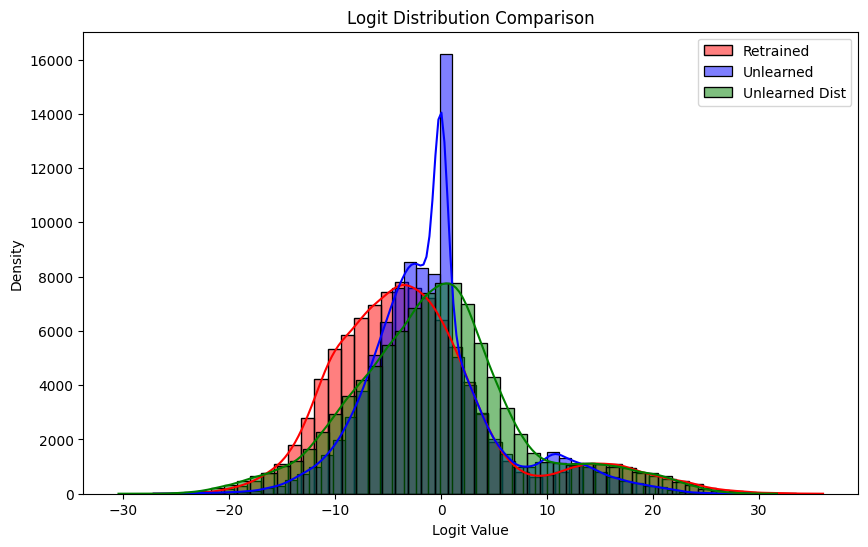

In [29]:
logits_unlearned_dist = collect_logits(unlearned_model_dist, test_loader_new, device)

# Plot histograms
plt.figure(figsize=(10, 6))
sns.histplot(logits_retrained, color="red", label="Retrained", bins=50, kde=True)
sns.histplot(logits_unlearned, color="blue", label="Unlearned", bins=50, kde=True)
sns.histplot(logits_unlearned_dist, color="green", label="Unlearned Dist", bins=50, kde=True)

# Labels and legend
plt.xlabel("Logit Value")
plt.ylabel("Density")
plt.title("Logit Distribution Comparison")
plt.legend()
plt.show()

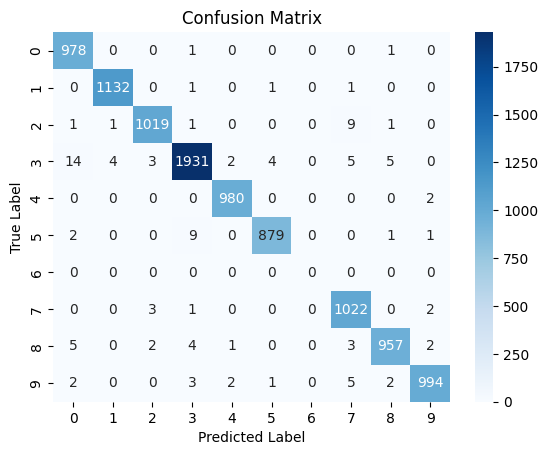

In [30]:
cm3 = compute_confusion_matrix(unlearned_model_dist, test_loader_new, device, num_classes)

sns.heatmap(cm3, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

plt.show()

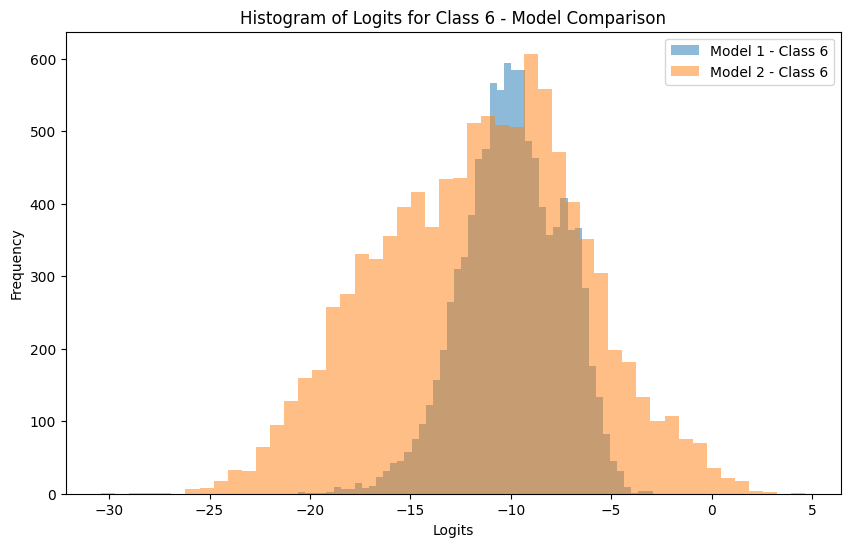

In [31]:
plot_logit_histograms(retrained_model, unlearned_model_dist, test_loader_new, device, class_label=6)